In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.xkcd()
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from tabulate import tabulate

Store is split into departments. 
Departments can be further split in aisles
aisles can be further split into products. 


# Reading Data Files

In [2]:
aisles = pd.read_csv('aisles.csv') #
dept = pd.read_csv('departments.csv') #
order_prior = pd.read_csv('order_products__prior.csv') #
order_train = pd.read_csv('order_products__train.csv') #
orders_info = pd.read_csv('orders.csv') #
products_info = pd.read_csv('products.csv') #

In [3]:
print(order_train.shape)
print(tabulate(order_train.head(), headers = 'keys', tablefmt='psql'))

(1384617, 4)
+----+------------+--------------+---------------------+-------------+
|    |   order_id |   product_id |   add_to_cart_order |   reordered |
|----+------------+--------------+---------------------+-------------|
|  0 |          1 |        49302 |                   1 |           1 |
|  1 |          1 |        11109 |                   2 |           1 |
|  2 |          1 |        10246 |                   3 |           0 |
|  3 |          1 |        49683 |                   4 |           0 |
|  4 |          1 |        43633 |                   5 |           1 |
+----+------------+--------------+---------------------+-------------+


In [4]:
print(order_prior.shape)
print(tabulate(order_prior.head(), headers = 'keys', tablefmt='psql'))

(32434489, 4)
+----+------------+--------------+---------------------+-------------+
|    |   order_id |   product_id |   add_to_cart_order |   reordered |
|----+------------+--------------+---------------------+-------------|
|  0 |          2 |        33120 |                   1 |           1 |
|  1 |          2 |        28985 |                   2 |           1 |
|  2 |          2 |         9327 |                   3 |           0 |
|  3 |          2 |        45918 |                   4 |           1 |
|  4 |          2 |        30035 |                   5 |           0 |
+----+------------+--------------+---------------------+-------------+


In [5]:
print(orders_info.shape)
print(tabulate(orders_info.head(), headers = 'keys', tablefmt='simple'))

(3421083, 7)
      order_id    user_id  eval_set      order_number    order_dow    order_hour_of_day    days_since_prior_order
--  ----------  ---------  ----------  --------------  -----------  -------------------  ------------------------
 0     2539329          1  prior                    1            2                    8                       nan
 1     2398795          1  prior                    2            3                    7                        15
 2      473747          1  prior                    3            3                   12                        21
 3     2254736          1  prior                    4            4                    7                        29
 4      431534          1  prior                    5            4                   15                        28


In [6]:
print(aisles.shape)
print(tabulate(aisles.head(), headers = 'keys', tablefmt='psql'))

(134, 2)
+----+------------+----------------------------+
|    |   aisle_id | aisle                      |
|----+------------+----------------------------|
|  0 |          1 | prepared soups salads      |
|  1 |          2 | specialty cheeses          |
|  2 |          3 | energy granola bars        |
|  3 |          4 | instant foods              |
|  4 |          5 | marinades meat preparation |
+----+------------+----------------------------+


In [7]:
print(dept.shape)
print(tabulate(dept.head(), headers = 'keys', tablefmt='psql'))

(21, 2)
+----+-----------------+--------------+
|    |   department_id | department   |
|----+-----------------+--------------|
|  0 |               1 | frozen       |
|  1 |               2 | other        |
|  2 |               3 | bakery       |
|  3 |               4 | produce      |
|  4 |               5 | alcohol      |
+----+-----------------+--------------+


In [8]:
print(products_info.shape)
print(tabulate(products_info.head(), headers = 'keys', tablefmt='simple'))

(49688, 4)
      product_id  product_name                                                         aisle_id    department_id
--  ------------  -----------------------------------------------------------------  ----------  ---------------
 0             1  Chocolate Sandwich Cookies                                                 61               19
 1             2  All-Seasons Salt                                                          104               13
 2             3  Robust Golden Unsweetened Oolong Tea                                       94                7
 3             4  Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce          38                1
 4             5  Green Chile Anytime Sauce                                                   5               13


### As we can see from above, the datasets can be broadly put into 2 categories:

1. Store layout, categories and products. 
2. Information on Orders and purchases. 


### The first category is made up by 3 files - dept, aisles and product_info.

Store is split into departments. 

Departments can be further split in aisles

aisles can be further split into products. 



### The second Category is made up of order_prior, order_train, order_info.

order_prior and order_train are similar datasets with same features. They are just different evaluation sets. For out pueposes we will focus on just order_prior

order_info provides further into on order details. 



### Lets explore our datasets. 

We will first merge the datasets from the first category and draw some visualizations. 




# Exploring Products DataSet

In [9]:
products = pd.merge(pd.merge(left = products_info, right = dept), aisles, sort = True)

In [10]:
print(products.shape)
products.head(5)

(49688, 6)


,product_id,product_name,aisle_id,department_id,department,aisle
0,209,Italian Pasta Salad,1,20,deli,prepared soups salads
1,554,Turkey Chili,1,20,deli,prepared soups salads
2,886,Whole Grain Salad with Roasted Pecans & Mango ...,1,20,deli,prepared soups salads
3,1600,Mediterranean Orzo Salad,1,20,deli,prepared soups salads
4,2539,Original Potato Salad,1,20,deli,prepared soups salads


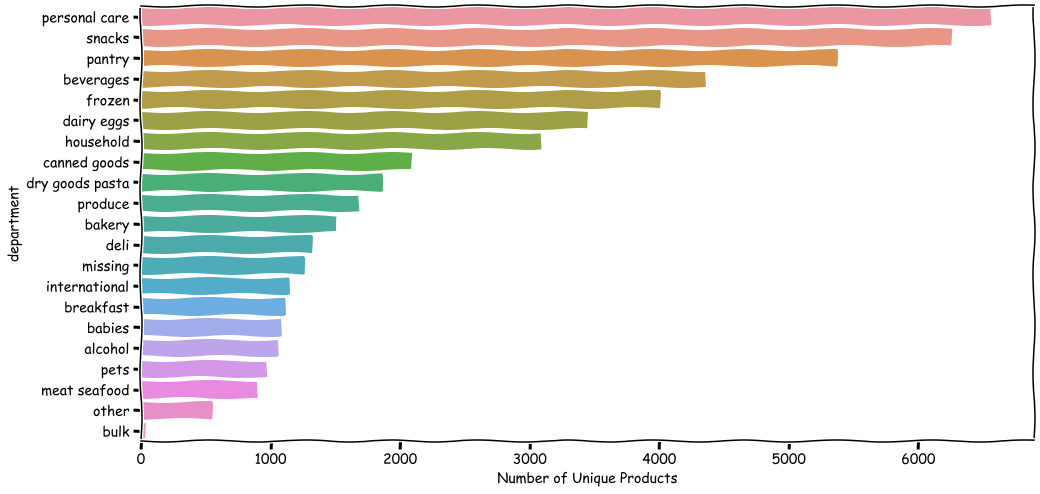

In [11]:
# Departments with most product categories
plt.xkcd()
plt.figure(figsize = (16, 8))
sns.countplot(y = products.department, order = products.department.value_counts().index)
plt.xlabel('Number of Unique Products')
plt.show()

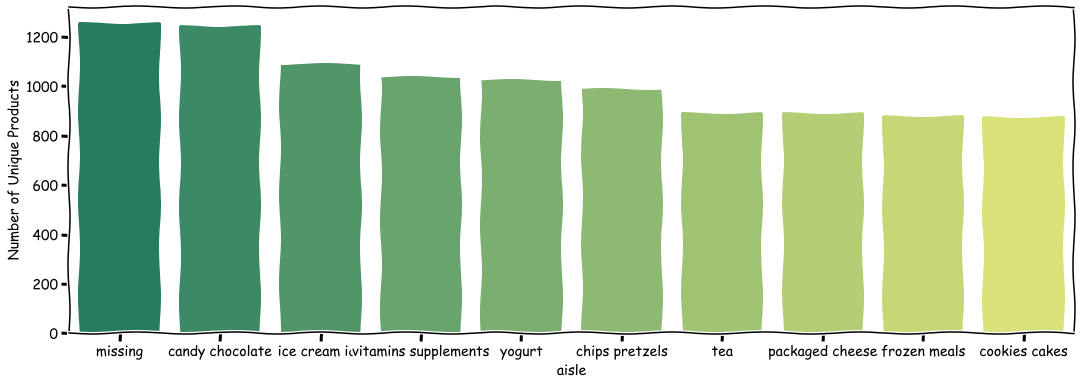

In [12]:
# Top 10 aisles with most product categories
plt.figure(figsize = (18, 6))
sns.countplot(x = products.aisle, order = products.aisle.value_counts().index[:10], palette = 'summer')
plt.ylabel('Number of Unique Products')
plt.savefig('aisles.png')

# Exploring Orders Dataset

In [14]:
orders_info.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [15]:
# forming a subset with the top 300000 rows, for the purpose of the project - to save up on computational time.
orders = orders_info[orders_info.eval_set == 'prior'].iloc[:300000]

In [16]:
order_prior = pd.merge(order_prior, orders)

In [17]:
order_prior.set_index('order_id', inplace = True)
order_prior.drop('eval_set',1,inplace = True)

In [18]:
order_prior.isna().sum() / len(order_prior) * 100

product_id                0.000000
add_to_cart_order         0.000000
reordered                 0.000000
user_id                   0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    6.434987
dtype: float64

In [19]:
order_prior.fillna(order_prior['days_since_prior_order'].mode()[0],
                                             inplace = True) # 7.0 is the mode value of this feature

In [20]:
order_prior = pd.merge(order_prior, products, on = 'product_id')

In [21]:
print(order_prior.shape)
temp = order_prior.rename(columns= {'add_to_cart_order':'add_cart',
                            'order_hour_of_day':'order_hod',
                            'days_since_prior_order': 'd_prior_o',
                                    'department':'dept',
                            'department_id':'dep_id'})
temp.head()

(3012547, 13)


,product_id,add_cart,reordered,user_id,order_number,order_dow,order_hod,d_prior_o,product_name,aisle_id,dep_id,dept,aisle
0,23423,1,1,3107,5,4,6,17.0,Original Hawaiian Sweet Rolls,43,3,bakery,buns rolls
1,23423,8,0,19074,1,5,18,7.0,Original Hawaiian Sweet Rolls,43,3,bakery,buns rolls
2,23423,2,1,13805,10,6,15,8.0,Original Hawaiian Sweet Rolls,43,3,bakery,buns rolls
3,23423,4,1,18865,11,5,9,10.0,Original Hawaiian Sweet Rolls,43,3,bakery,buns rolls
4,23423,7,1,1699,52,3,8,8.0,Original Hawaiian Sweet Rolls,43,3,bakery,buns rolls


### Most ordered and Re-ordered Products

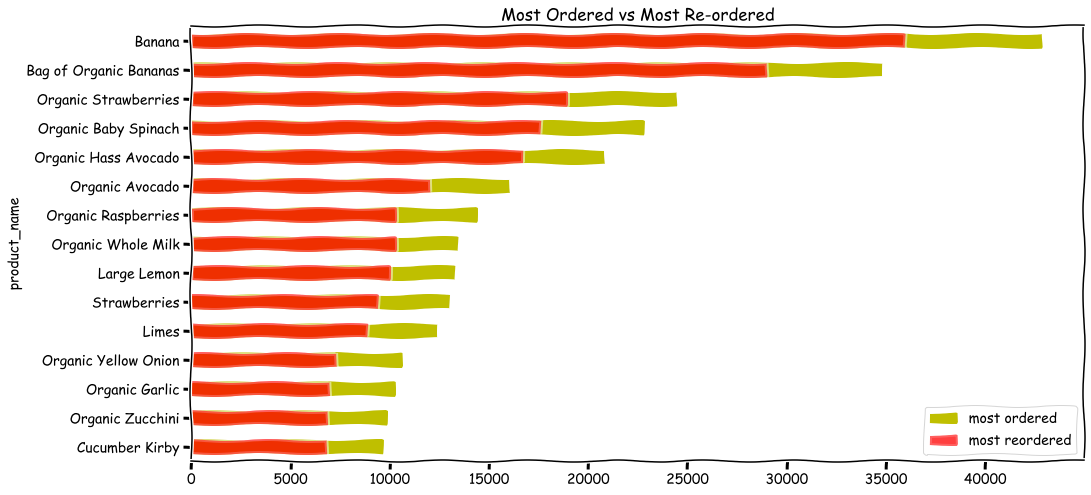

In [22]:
order_prior.product_name.value_counts()[:15].sort_values(ascending = True).plot(kind = 'barh',
                                                                                figsize = (16,8), color = 'y', label = 'most ordered')

order_prior.groupby('product_name')['reordered'].sum().sort_values(ascending = False)[:15].sort_values(ascending = True).plot(kind = 'barh',
                                                                                figsize = (16,8), color = 'r', alpha = 0.5, label = 'most reordered')

plt.legend()
plt.title('Most Ordered vs Most Re-ordered')
plt.savefig('Most Ordered vs Re-ordered.png')

## Understanding Order Distribution over the Week

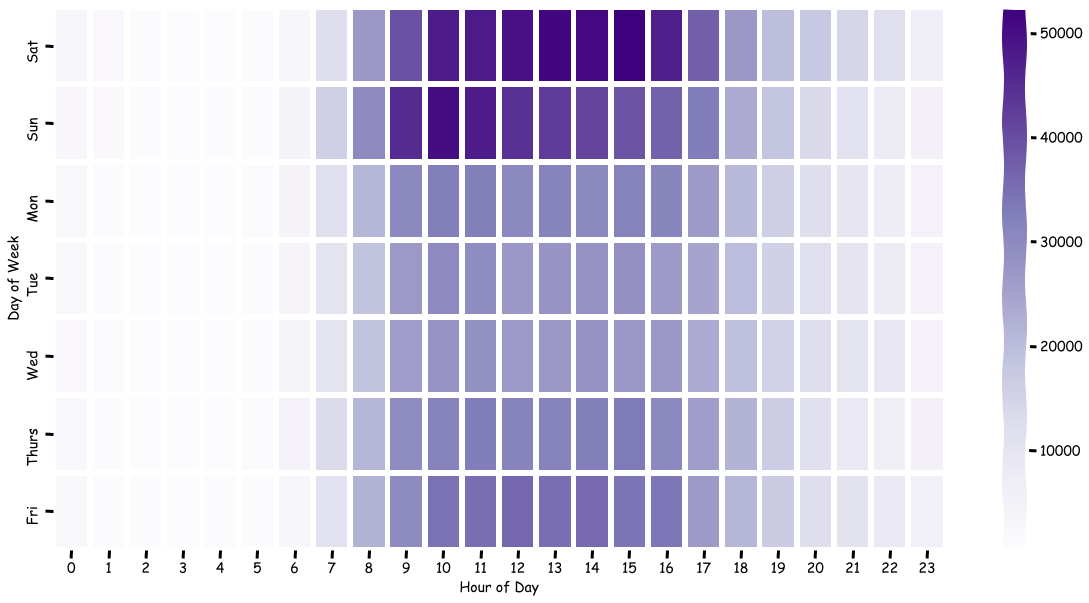

In [23]:
plt.figure(figsize = (20,10))
sns.heatmap(pd.crosstab(index = order_prior['order_dow'], columns = order_prior['order_hour_of_day']),
           cmap = 'Purples',linewidth = 5)
plt.yticks(np.arange(7) + 0.5,('Sat','Sun','Mon','Tue','Wed','Thurs','Fri'))
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.savefig('order_distribution.png')

# Clustering

In [24]:
crosstab_aisle = pd.crosstab(order_prior['user_id'], order_prior['aisle'])

In [25]:
pd.set_option('max_columns',15)
crosstab_aisle

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,...,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,...,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,...,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19336,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0
19337,0,0,0,0,0,0,0,...,0,0,0,0,1,7,0
19338,0,0,0,0,0,0,3,...,0,0,0,1,2,0,14


## 1. Using T-SNE for Dimension Reduction

In [26]:
from sklearn.manifold import TSNE
import time

t0 = time.time()
tsne_aisle = TSNE(n_components = 2)
tsne_aisle_trans = tsne_aisle.fit_transform(crosstab_aisle)
t1 = time.time()

print('Time taken:', t1 - t0)

Time taken: 367.4336061477661


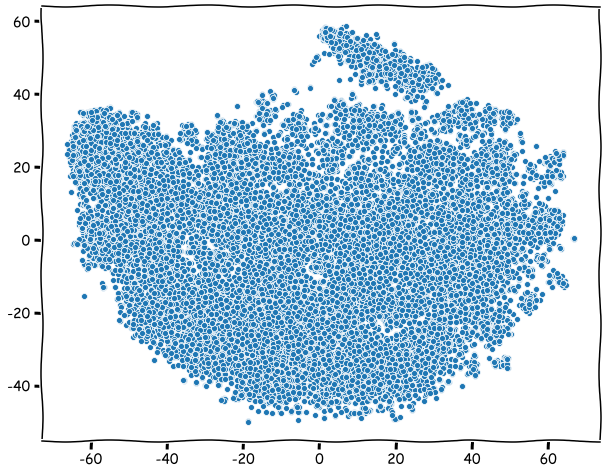

In [27]:
plt.figure(figsize = (10,8))
sns.scatterplot(tsne_aisle_trans[:,0], tsne_aisle_trans[:,1])

In [28]:
from tqdm import tqdm
from sklearn.cluster import KMeans

X = tsne_aisle_trans[:,[0,1]]

wcss_tsne =[]
for i in tqdm(range(1,30)):
    kmeans_tsne = KMeans(n_clusters = i, random_state = 0)
    kmeans_tsne = kmeans_tsne.fit(X)
    wcss_tsne.append(kmeans_tsne.inertia_)

100%|██████████| 29/29 [01:20<00:00,  2.78s/it]


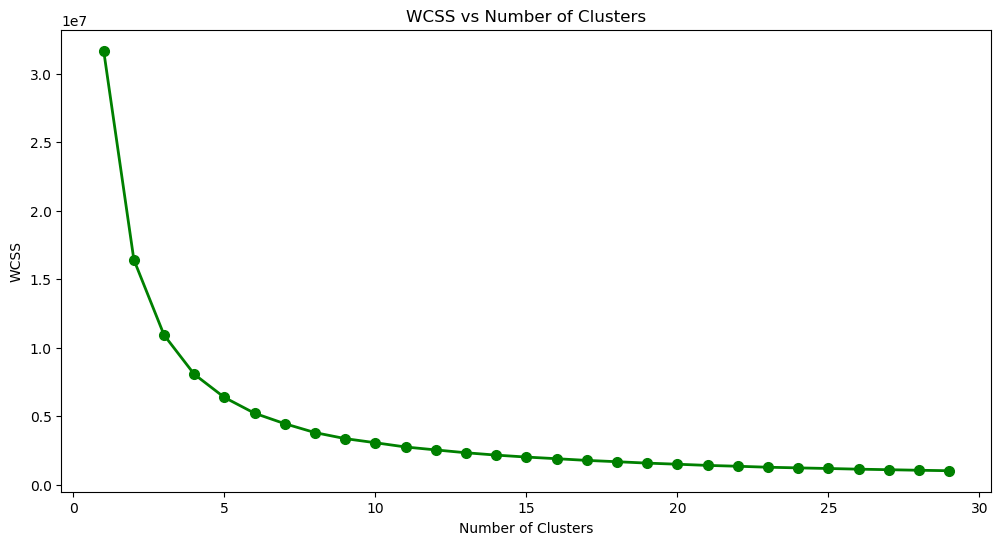

In [29]:
plt.rcdefaults()
plt.figure(figsize = (12,6))
plt.plot(range(1,30), wcss_tsne, marker = 'o', lw = 2, color = 'g', markersize = 7)
plt.title('WCSS vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [30]:
kmeans_aisle_tsne = KMeans(n_clusters = 5, random_state = 10)

kmeans_aisle_tsne.fit(tsne_aisle_trans[:,[0,1]])

aisle_clusters_tsne = kmeans_aisle_tsne.predict(tsne_aisle_trans[:,[0,1]])

crosstab_aisle['Cluster_tsne'] = aisle_clusters_tsne

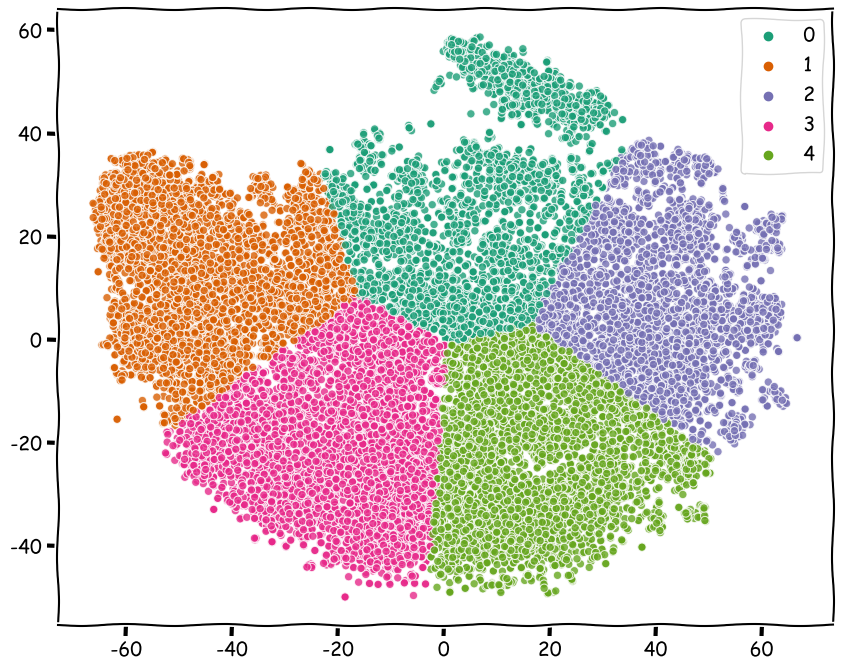

In [31]:
plt.xkcd()
plt.figure(figsize = (10,8))
sns.scatterplot(x = tsne_aisle_trans[:,0],
               y = tsne_aisle_trans[:,1], alpha = 0.8, hue = aisle_clusters_tsne, palette = 'Dark2')
plt.savefig('Clusters_tsne.jpg')

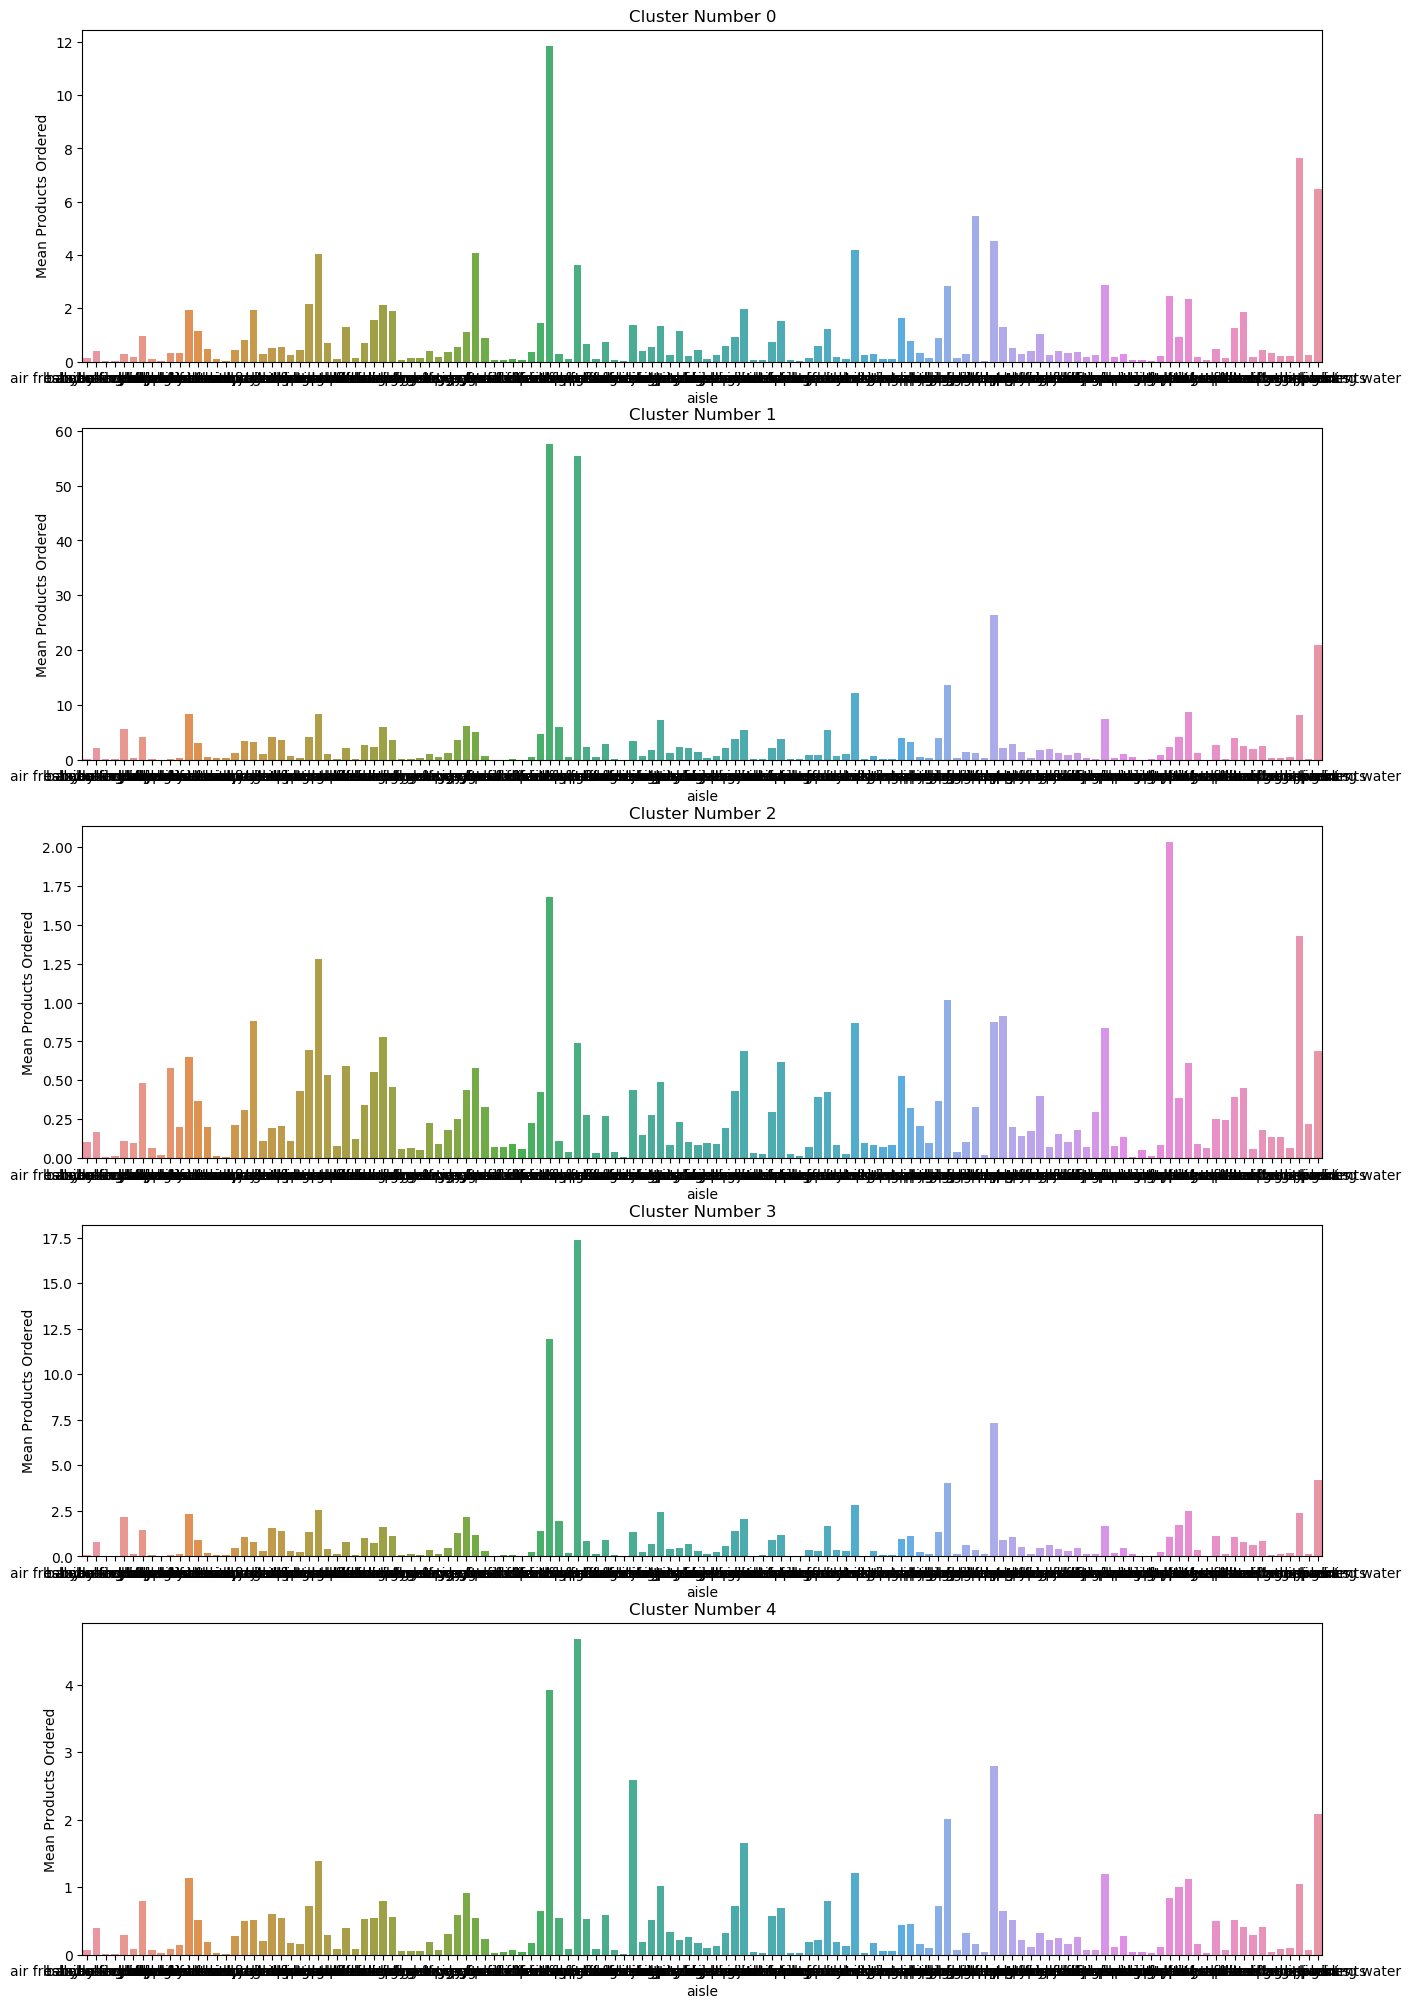

In [32]:
plt.rcdefaults()
fig, ax = plt.subplots(5,1, figsize = (16,25))

cluster_no = 0
for i in range(5):
    sns.barplot(x = crosstab_aisle[crosstab_aisle.Cluster_tsne == cluster_no].iloc[:,:-1].mean().index,
        y = crosstab_aisle[crosstab_aisle.Cluster_tsne == cluster_no].iloc[:,:-1].mean(), ax = ax[i])
    ax[i].set_ylabel('Mean Products Ordered')
    ax[i].set_title('Cluster Number {}'.format(i))
    cluster_no = cluster_no + 1
    
plt.savefig('clusters tsne.png')

In [33]:
aisle_clus0_tsne = order_prior.set_index('user_id').loc[crosstab_aisle[crosstab_aisle.Cluster_tsne == 0].index.tolist()]
aisle_clus1_tsne = order_prior.set_index('user_id').loc[crosstab_aisle[crosstab_aisle.Cluster_tsne == 1].index.tolist()]
aisle_clus2_tsne = order_prior.set_index('user_id').loc[crosstab_aisle[crosstab_aisle.Cluster_tsne == 2].index.tolist()]
aisle_clus3_tsne = order_prior.set_index('user_id').loc[crosstab_aisle[crosstab_aisle.Cluster_tsne == 3].index.tolist()]
aisle_clus4_tsne = order_prior.set_index('user_id').loc[crosstab_aisle[crosstab_aisle.Cluster_tsne == 4].index.tolist()]

In [34]:
round(aisle_clus0_tsne.aisle.value_counts(normalize = False)[:15]/len(np.unique(aisle_clus0_tsne.index.values)),2)

fresh fruits                     11.86
water seltzer sparkling water     7.64
yogurt                            6.46
packaged produce                  5.45
packaged vegetables fruits        4.54
milk                              4.18
energy granola bars               4.09
chips pretzels                    4.03
fresh vegetables                  3.62
refrigerated                      2.86
packaged cheese                   2.83
soft drinks                       2.46
soy lactosefree                   2.34
cereal                            2.16
crackers                          2.13
Name: aisle, dtype: float64

In [35]:
round(aisle_clus1_tsne.aisle.value_counts(normalize = False)[:15]/len(np.unique(aisle_clus1_tsne.index.values)),2)

fresh fruits                     57.61
fresh vegetables                 55.43
packaged vegetables fruits       26.50
yogurt                           20.86
packaged cheese                  13.63
milk                             12.24
soy lactosefree                   8.71
bread                             8.29
chips pretzels                    8.27
water seltzer sparkling water     8.20
refrigerated                      7.40
frozen produce                    7.23
eggs                              6.24
fresh herbs                       6.08
crackers                          5.92
Name: aisle, dtype: float64

In [36]:
round(aisle_clus2_tsne.aisle.value_counts(normalize = False)[:15]/len(np.unique(aisle_clus2_tsne.index.values)),2)

soft drinks                      2.03
fresh fruits                     1.67
water seltzer sparkling water    1.43
chips pretzels                   1.28
packaged cheese                  1.01
paper goods                      0.91
candy chocolate                  0.88
packaged vegetables fruits       0.87
milk                             0.87
refrigerated                     0.84
crackers                         0.78
fresh vegetables                 0.74
cereal                           0.70
ice cream ice                    0.69
yogurt                           0.69
Name: aisle, dtype: float64

In [37]:
round(aisle_clus3_tsne.aisle.value_counts(normalize = False)[:15]/len(np.unique(aisle_clus3_tsne.index.values)), 2)

fresh vegetables                 17.35
fresh fruits                     11.92
packaged vegetables fruits        7.30
yogurt                            4.20
packaged cheese                   4.04
milk                              2.83
chips pretzels                    2.53
soy lactosefree                   2.51
frozen produce                    2.42
water seltzer sparkling water     2.37
bread                             2.33
baby food formula                 2.19
eggs                              2.16
ice cream ice                     2.06
fresh herbs                       1.92
Name: aisle, dtype: float64

In [38]:
round(aisle_clus4_tsne.aisle.value_counts(normalize = False)[:15]/len(np.unique(aisle_clus4_tsne.index.values)),2)

fresh vegetables                 4.68
fresh fruits                     3.92
packaged vegetables fruits       2.80
frozen meals                     2.58
yogurt                           2.09
packaged cheese                  2.01
ice cream ice                    1.65
chips pretzels                   1.39
milk                             1.21
refrigerated                     1.20
bread                            1.14
soy lactosefree                  1.12
water seltzer sparkling water    1.04
frozen produce                   1.02
soup broth bouillon              1.01
Name: aisle, dtype: float64

In [39]:
common_index_tsne = (aisle_clus0_tsne.aisle.value_counts()[:15].index) & \
(aisle_clus1_tsne.aisle.value_counts()[:15].index) & \
(aisle_clus2_tsne.aisle.value_counts()[:15].index) & \
(aisle_clus3_tsne.aisle.value_counts()[:15].index) & \
(aisle_clus4_tsne.aisle.value_counts()[:15].index)

In [40]:
tsne_df = pd.DataFrame(columns = common_index_tsne, index = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3'])

tsne_df.loc['Cluster 0'] = aisle_clus0_tsne.aisle.value_counts()[common_index_tsne].values
tsne_df.loc['Cluster 1'] = aisle_clus1_tsne.aisle.value_counts()[common_index_tsne].values
tsne_df.loc['Cluster 2'] = aisle_clus2_tsne.aisle.value_counts()[common_index_tsne].values
tsne_df.loc['Cluster 3'] = aisle_clus3_tsne.aisle.value_counts()[common_index_tsne].values
tsne_df.loc['Cluster 4'] = aisle_clus4_tsne.aisle.value_counts()[common_index_tsne].values
tsne_df['Total'] = tsne_df.sum(axis = 1)

for column in tsne_df.columns:
    column_temp = tsne_df[column]/(tsne_df[column].sum())*100
    tsne_df[column] = round(column_temp.astype('float64'),2)

tsne_df

,fresh fruits,water seltzer sparkling water,yogurt,packaged vegetables fruits,milk,chips pretzels,fresh vegetables,packaged cheese,Total
Cluster 0,12.08,33.73,16.81,9.50,17.48,20.62,3.85,10.59,12.17
Cluster 1,66.31,40.93,61.30,62.67,57.90,47.81,66.59,57.64,61.71
Cluster 2,1.88,6.94,1.96,2.01,3.99,7.20,0.87,4.18,2.54
Cluster 3,15.02,12.97,13.53,18.90,14.65,15.99,22.81,18.70,17.51
Cluster 4,4.71,5.43,6.41,6.91,5.97,8.39,5.88,8.89,6.08


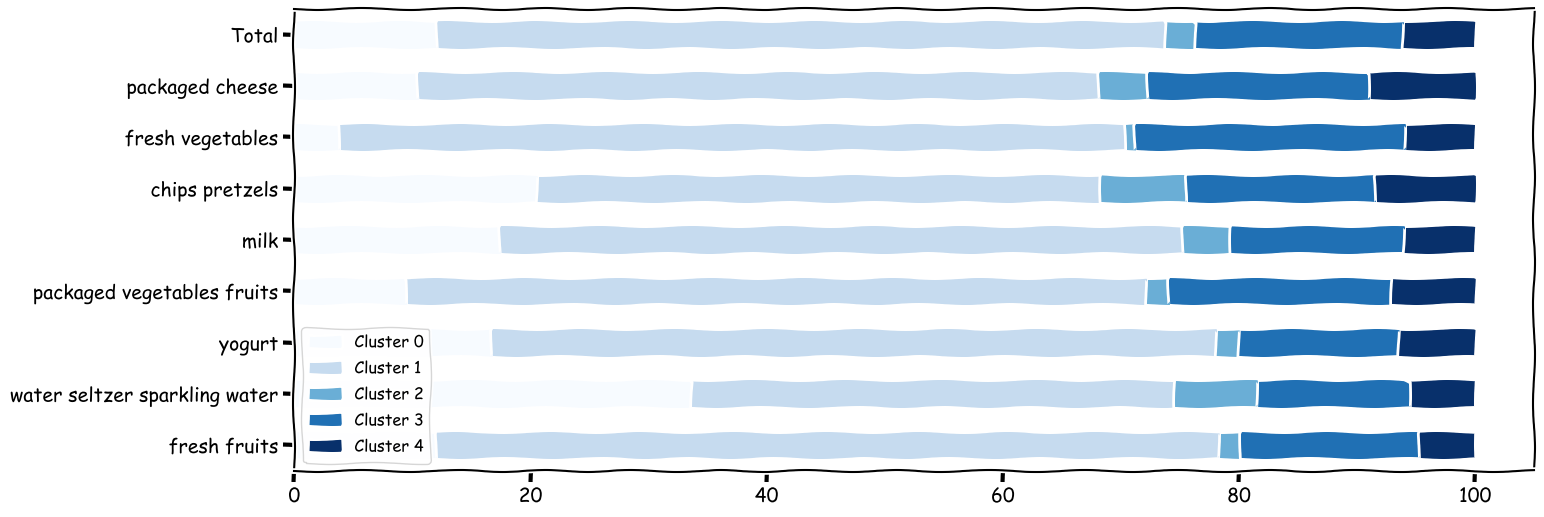

In [41]:
plt.xkcd()
tsne_df.T.plot(kind='barh', stacked=True, cmap = 'Blues',figsize = (16,6))
plt.legend(loc = 3, fontsize = 'small')
plt.savefig('tsne_df.jpg', bbox_inches='tight', quality = 95)

In [42]:
np.round(crosstab_aisle['Cluster_tsne'].value_counts(normalize = True).sort_index()*100,2)

0    17.71
1    20.01
2    19.47
3    21.91
4    20.90
Name: Cluster_tsne, dtype: float64

## 2. Using PCA for Dimension Reduction

In [43]:
from sklearn.decomposition import PCA

pca_aisle = PCA(n_components = 6)

pca_aisle_trans = pca_aisle.fit_transform(crosstab_aisle)

pca_aisle.explained_variance_ratio_

array([0.48660314, 0.09250327, 0.04691264, 0.03374186, 0.02654108,
       0.02288264])

Text(0.5, 1, 'Pair Plot | PCA Components')

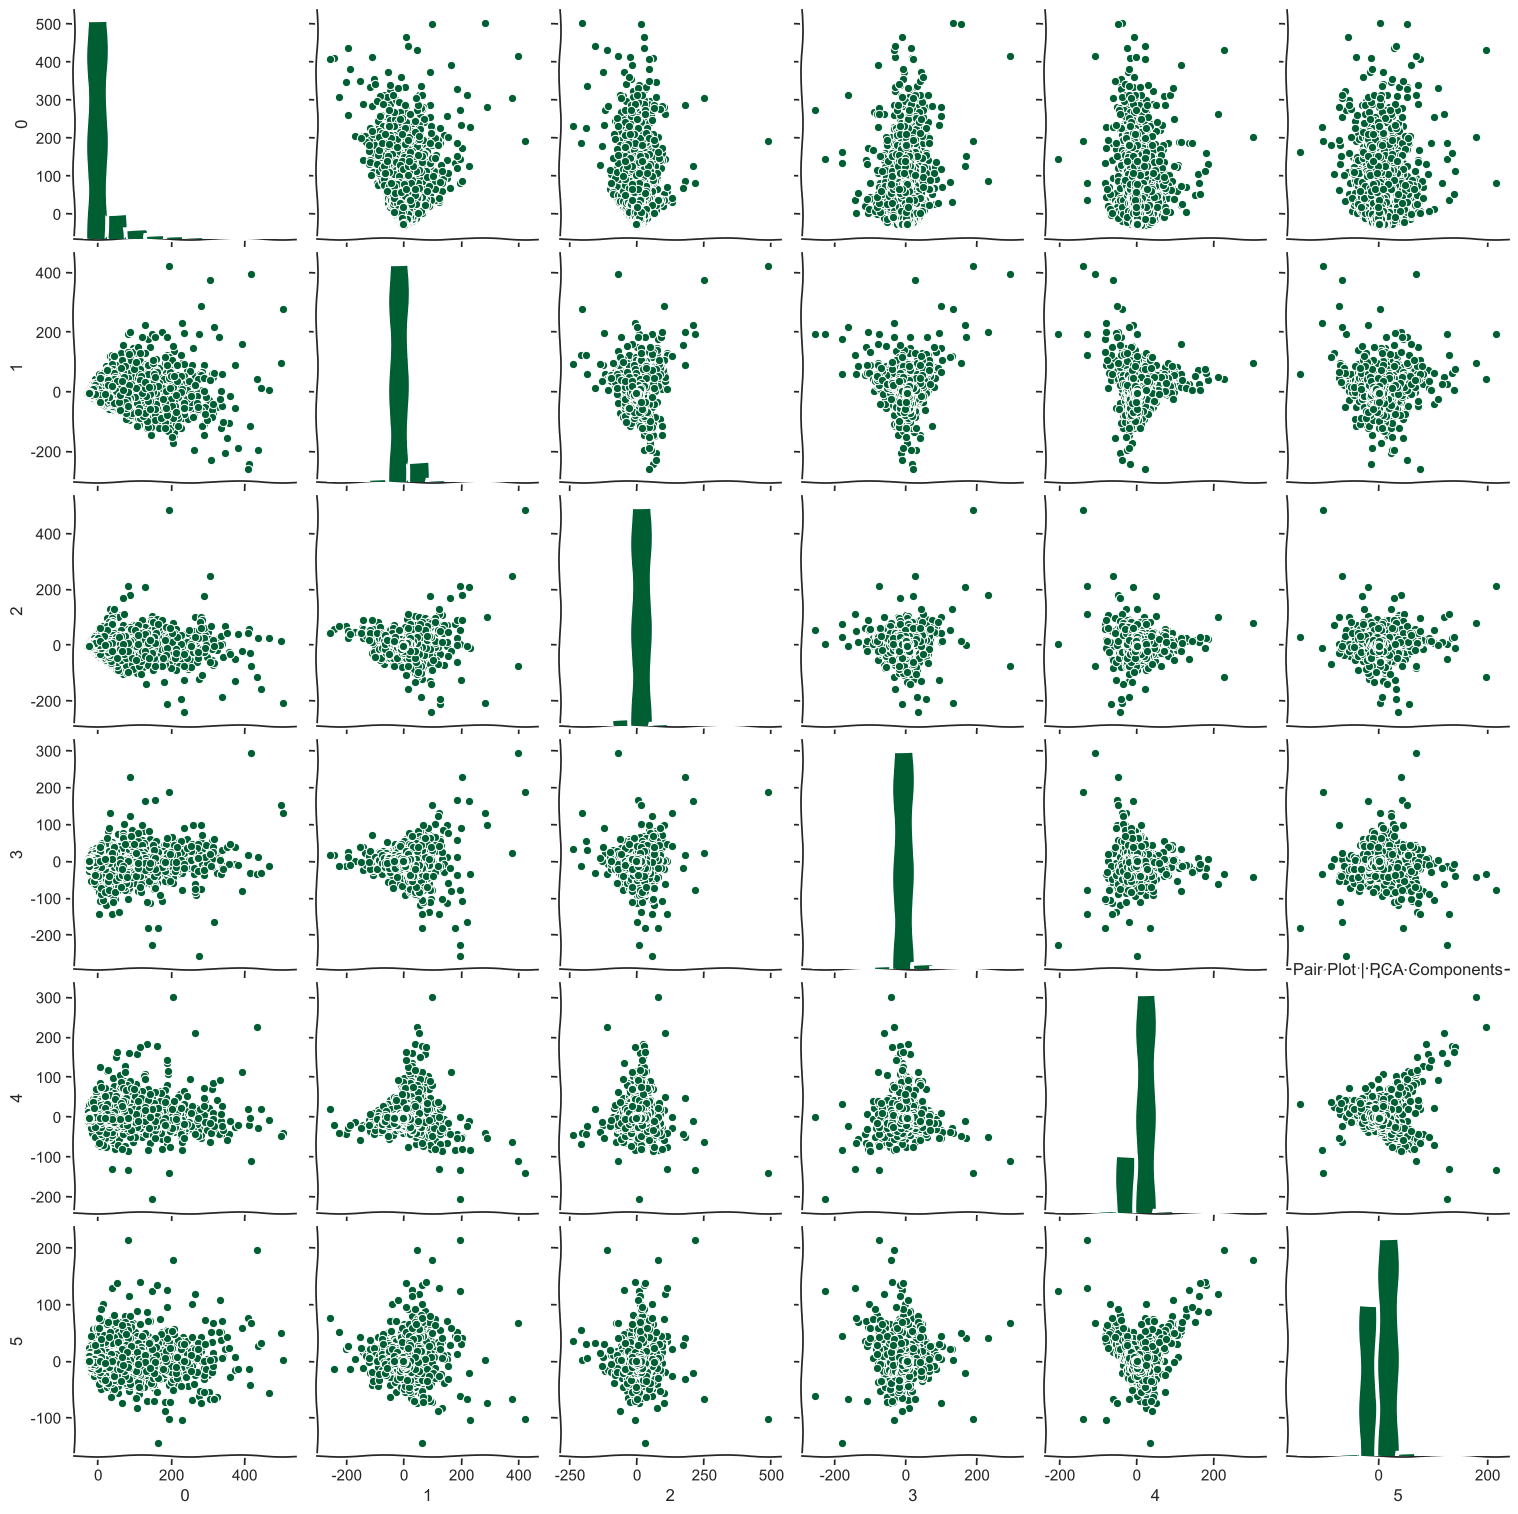

In [44]:
sns.set(style="ticks", color_codes=True,palette = sns.color_palette("YlGn_r", 10))
sns.pairplot(pd.DataFrame(pca_aisle_trans))
plt.savefig('pairplots.JPEG',bbox_inches='tight')
plt.title('Pair Plot | PCA Components')

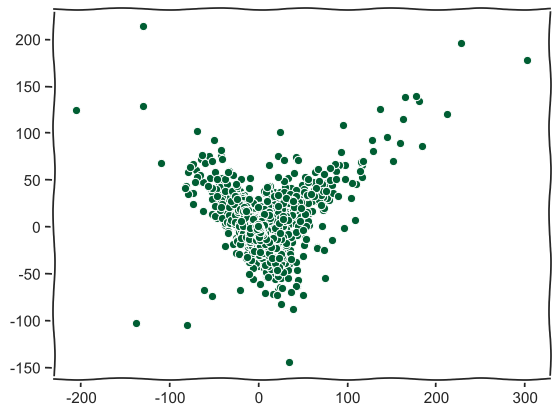

In [45]:
sns.scatterplot(pca_aisle_trans[:,4], pca_aisle_trans[:,5])

In [46]:
from tqdm import tqdm

X = pca_aisle_trans[:,[4,5]]

wcss_pca =[]
for i in tqdm(range(1,30)):
    kmeans_pca = KMeans(n_clusters = i, random_state = 0)
    kmeans_pca = kmeans_pca.fit(X)
    wcss_pca.append(kmeans_pca.inertia_)

100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


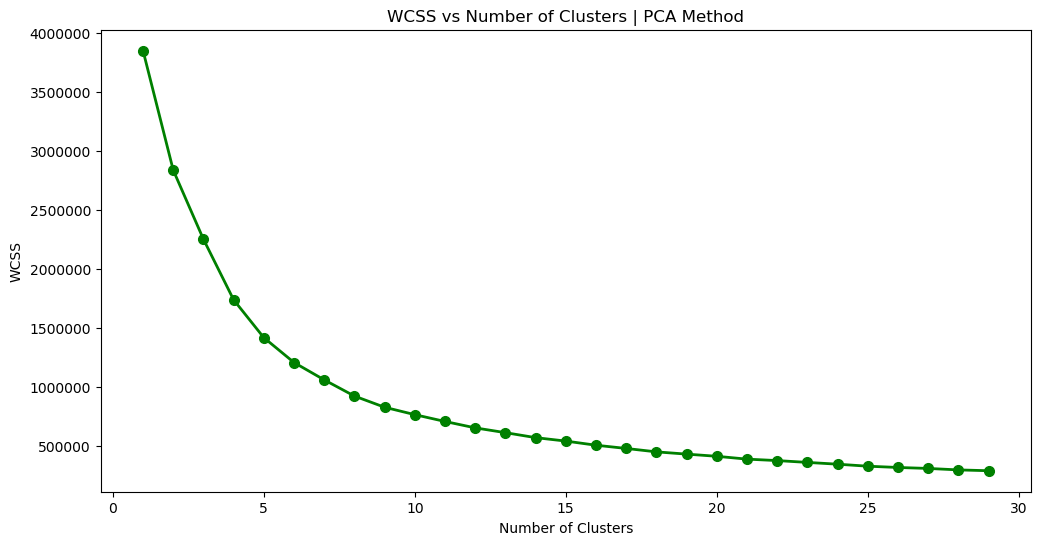

In [47]:
plt.rcdefaults()
plt.figure(figsize = (12,6))
plt.plot(range(1,30), wcss_pca, marker = 'o', lw = 2, color = 'g', markersize = 7)
plt.title('WCSS vs Number of Clusters | PCA Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [48]:
kmeans_aisle_pca = KMeans(n_clusters = 4, random_state = 10)

kmeans_aisle_pca.fit(pca_aisle_trans[:,[4,5]])

aisle_clusters_pca = kmeans_aisle_pca.predict(pca_aisle_trans[:,[4,5]])

crosstab_aisle['Cluster_PCA'] = aisle_clusters_pca

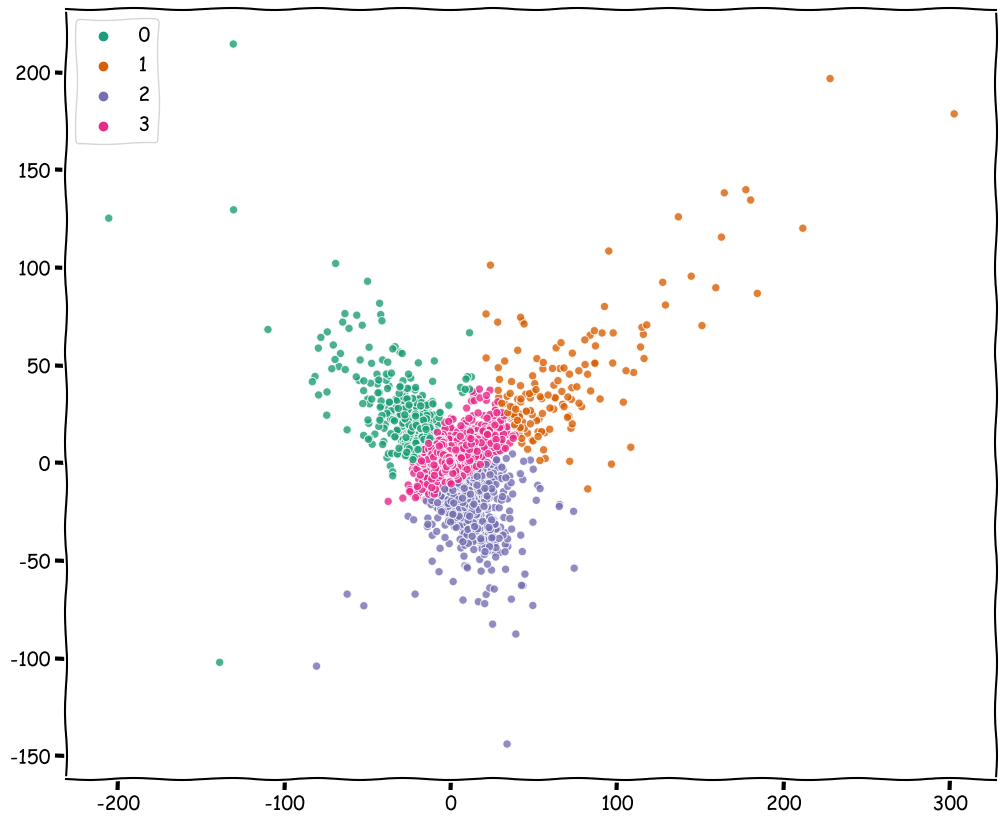

In [49]:
plt.xkcd()
plt.figure(figsize = (12,10))
sns.scatterplot(x = pca_aisle_trans[:,4],
               y = pca_aisle_trans[:,5], alpha = 0.8, hue = aisle_clusters_pca,
                palette = sns.color_palette("Dark2", 4))
plt.savefig('clusters pca.JPEG')

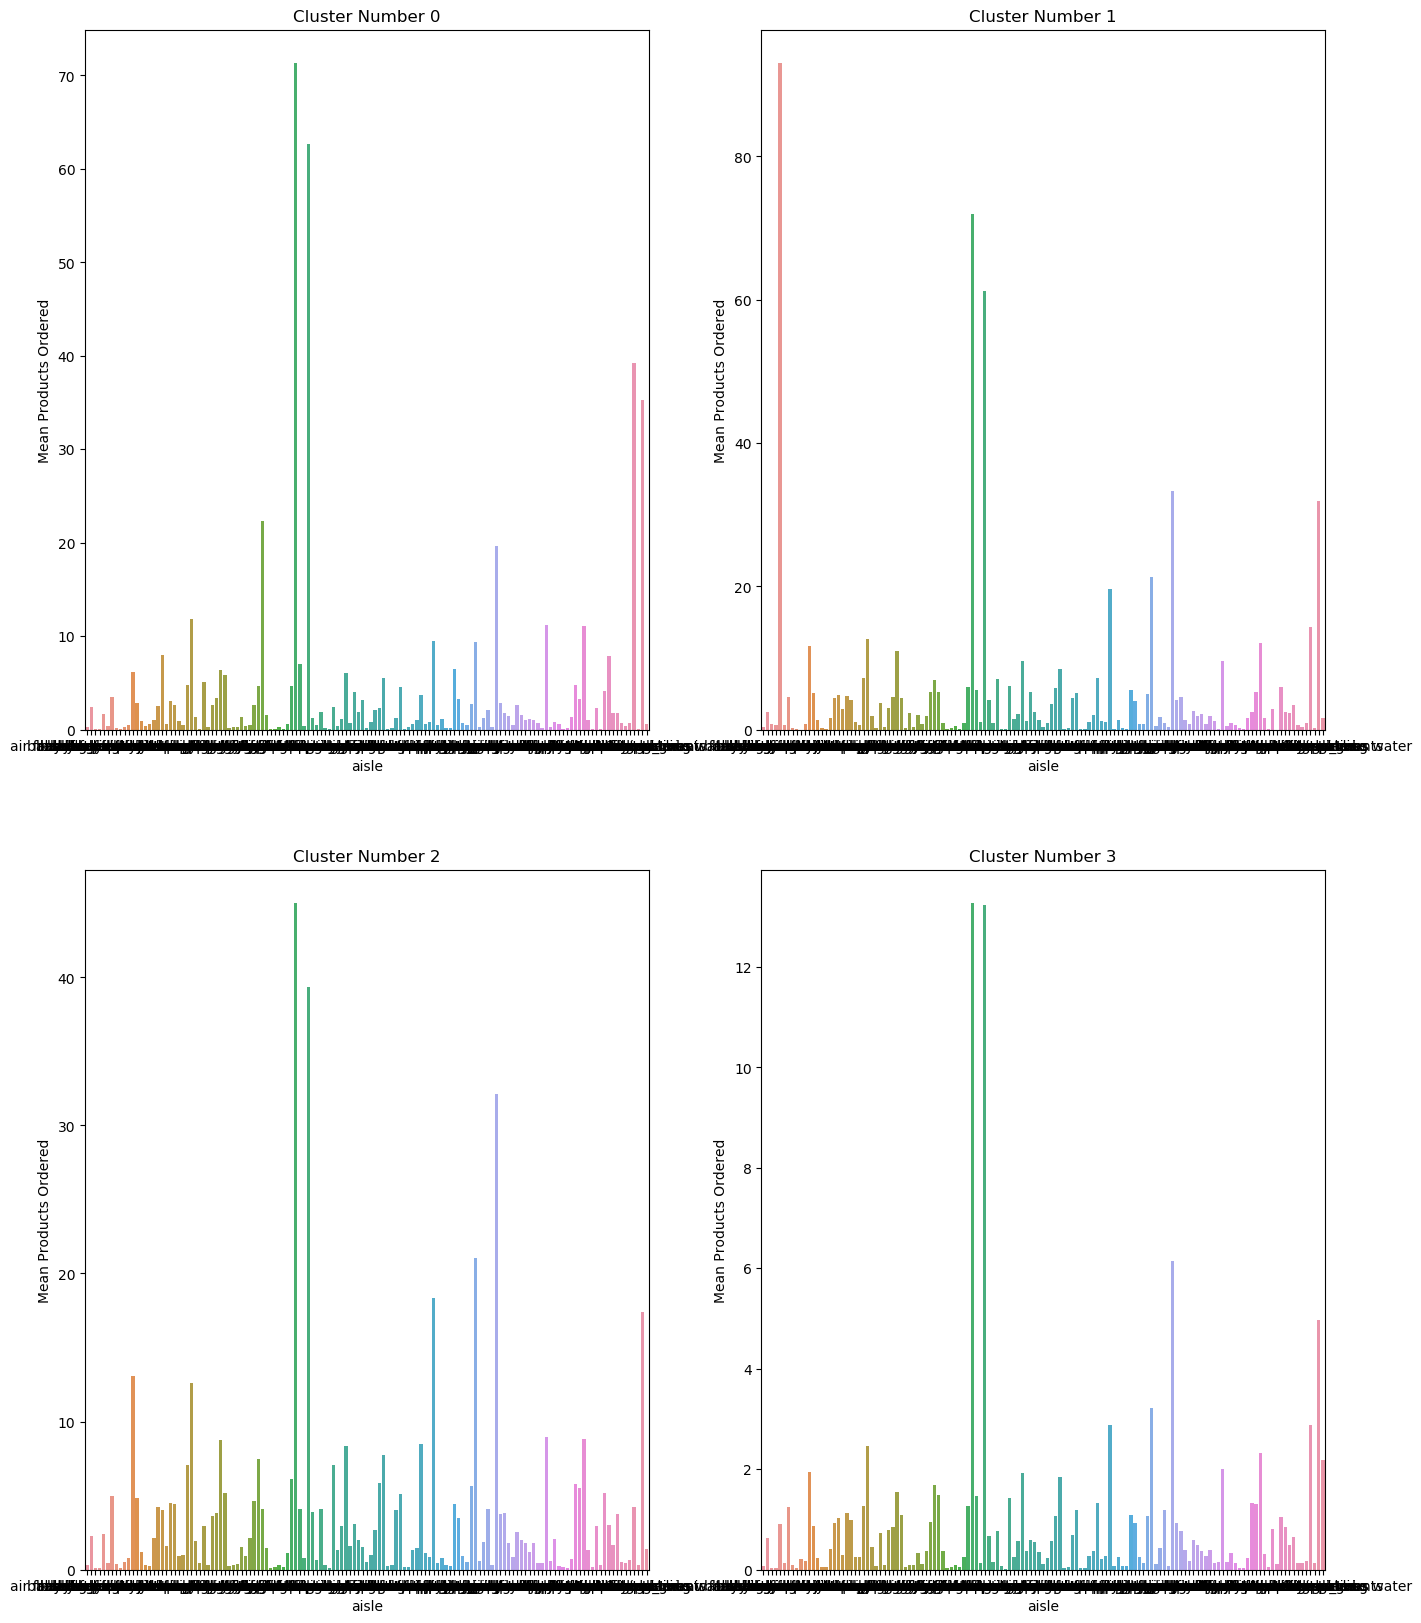

In [50]:
plt.rcdefaults()
fig, ax = plt.subplots(2,2, figsize = (16,20))

cluster_no = 0
for i in range(2):
    for j in range(2):
        sns.barplot(x = crosstab_aisle[crosstab_aisle.Cluster_PCA == cluster_no].iloc[:,:-1].mean().index,
            y = crosstab_aisle[crosstab_aisle.Cluster_PCA == cluster_no].iloc[:,:-1].mean(), ax = ax[i,j])
        ax[i,j].set_ylabel('Mean Products Ordered')
        ax[i,j].set_title('Cluster Number {}'.format(i + j + i))
        cluster_no = cluster_no + 1
        
plt.savefig('cluster graphs pca.JPEG')

In [51]:
crosstab_aisle[crosstab_aisle.Cluster_PCA == 3]['fresh vegetables'].mean()

13.234190689913113

In [52]:
aisle_clus0_pca = order_prior.set_index('user_id').loc[crosstab_aisle[crosstab_aisle.Cluster_PCA == 0].index.tolist()]
aisle_clus1_pca = order_prior.set_index('user_id').loc[crosstab_aisle[crosstab_aisle.Cluster_PCA == 1].index.tolist()]
aisle_clus2_pca = order_prior.set_index('user_id').loc[crosstab_aisle[crosstab_aisle.Cluster_PCA == 2].index.tolist()]
aisle_clus3_pca = order_prior.set_index('user_id').loc[crosstab_aisle[crosstab_aisle.Cluster_PCA == 3].index.tolist()]

In [53]:
aisle_clus0_pca.aisle.value_counts(normalize = False)[:15]/len(np.unique(aisle_clus0_pca.index.values))

fresh fruits                     71.335984
fresh vegetables                 62.612326
water seltzer sparkling water    39.216700
yogurt                           35.248509
energy granola bars              22.351889
packaged vegetables fruits       19.596421
chips pretzels                   11.838966
refrigerated                     11.178926
soy lactosefree                  11.047714
milk                              9.520875
packaged cheese                   9.383698
candy chocolate                   7.958250
tea                               7.850895
fresh herbs                       7.065606
nuts seeds dried fruit            6.504970
Name: aisle, dtype: float64

In [54]:
aisle_clus1_pca.aisle.value_counts(normalize = False)[:15]/len(np.unique(aisle_clus1_pca.index.values))

baby food formula                93.053333
fresh fruits                     72.033333
fresh vegetables                 61.286667
packaged vegetables fruits       33.293333
yogurt                           31.893333
packaged cheese                  21.353333
milk                             19.560000
water seltzer sparkling water    14.333333
chips pretzels                   12.666667
soy lactosefree                  12.020000
bread                            11.640000
crackers                         10.953333
refrigerated                      9.640000
frozen produce                    9.613333
ice cream ice                     8.493333
Name: aisle, dtype: float64

In [55]:
aisle_clus2_pca.aisle.value_counts(normalize = False)[:15]/len(np.unique(aisle_clus2_pca.index.values))

fresh fruits                  45.031346
fresh vegetables              39.344801
packaged vegetables fruits    32.117737
packaged cheese               21.035933
milk                          18.342508
yogurt                        17.425841
bread                         13.071865
chips pretzels                12.627676
refrigerated                   8.967890
soy lactosefree                8.801223
crackers                       8.729358
lunch meat                     8.472477
frozen produce                 8.352446
ice cream ice                  7.726300
eggs                           7.454128
Name: aisle, dtype: float64

In [56]:
aisle_clus3_pca.aisle.value_counts(normalize = False)[:15]/len(np.unique(aisle_clus3_pca.index.values))

fresh fruits                     13.271995
fresh vegetables                 13.234191
packaged vegetables fruits        6.142298
yogurt                            4.970251
packaged cheese                   3.224639
water seltzer sparkling water     2.886357
milk                              2.883883
chips pretzels                    2.451637
soy lactosefree                   2.320502
refrigerated                      1.996548
bread                             1.932850
frozen produce                    1.922493
ice cream ice                     1.835951
eggs                              1.685080
crackers                          1.553311
Name: aisle, dtype: float64

In [57]:
common_index_pca = (aisle_clus0_pca.aisle.value_counts()[:15].index) & \
(aisle_clus1_pca.aisle.value_counts()[:15].index) & \
(aisle_clus2_pca.aisle.value_counts()[:15].index) & \
(aisle_clus3_pca.aisle.value_counts()[:15].index)

In [58]:
pca_df = pd.DataFrame(columns = common_index_pca, index = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3'])

pca_df.loc['Cluster 0'] = aisle_clus0_pca.aisle.value_counts()[common_index_pca].values
pca_df.loc['Cluster 1'] = aisle_clus1_pca.aisle.value_counts()[common_index_pca].values
pca_df.loc['Cluster 2'] = aisle_clus2_pca.aisle.value_counts()[common_index_pca].values
pca_df.loc['Cluster 3'] = aisle_clus3_pca.aisle.value_counts()[common_index_pca].values
pca_df['Total'] = pca_df.sum(axis = 1)

for column in pca_df.columns:
    column_temp = pca_df[column]/(pca_df[column].sum())*100
    pca_df[column] = round(column_temp.astype('float64'),2)

pca_df

,fresh fruits,fresh vegetables,yogurt,packaged vegetables fruits,chips pretzels,refrigerated,soy lactosefree,milk,packaged cheese,Total
Cluster 0,10.67,9.78,13.46,6.02,8.89,10.51,9.39,5.85,5.16,9.31
Cluster 1,3.21,2.85,3.63,3.05,2.84,2.70,3.05,3.59,3.50,3.14
Cluster 2,17.52,15.98,17.31,25.68,24.66,21.93,19.45,29.32,30.08,20.39
Cluster 3,68.60,71.40,65.59,65.25,63.61,64.86,68.12,61.24,61.26,67.16


In [59]:
round(crosstab_aisle['Cluster_PCA'].value_counts(normalize = True).sort_index()*100, 2)

0     2.60
1     0.78
2     6.76
3    89.86
Name: Cluster_PCA, dtype: float64

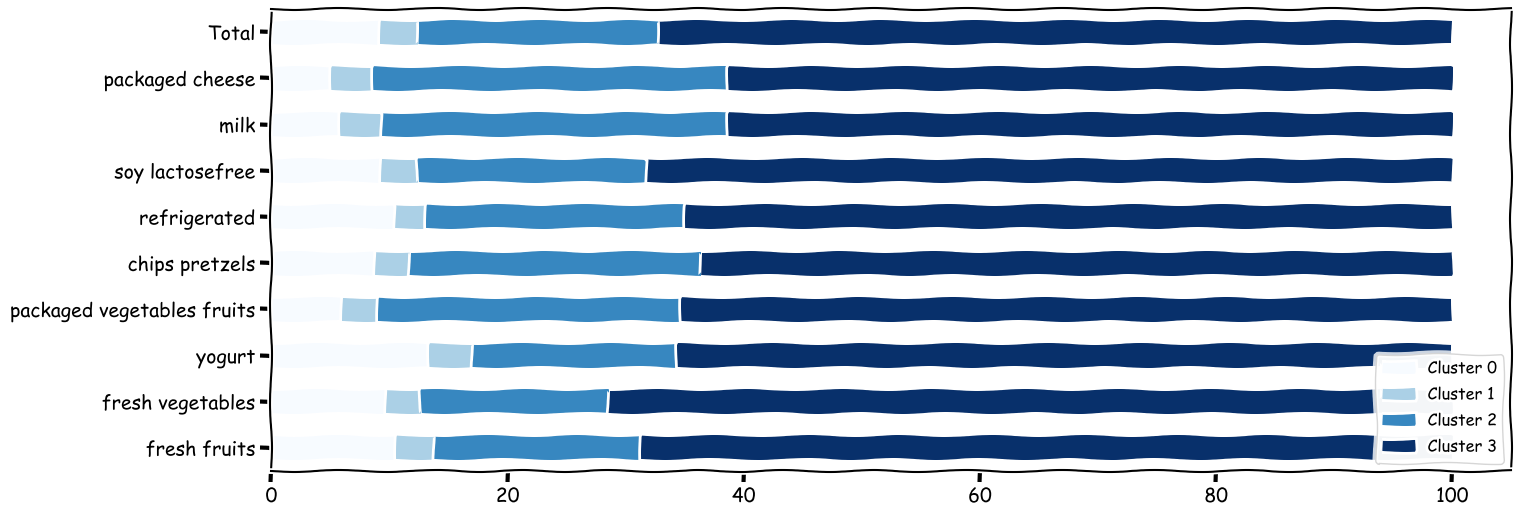

In [60]:
plt.xkcd()
pca_df.T.plot(kind='barh', stacked=True, cmap = 'Blues',figsize = (16,6))
plt.legend(loc = 4, fontsize = 'small')
plt.savefig('pca_df.jpg', bbox_inches='tight', quality = 95)